# Set-up

In [1]:
# Imports
import os
import numpy as np
import pandas as pd
import torch
import xarray as xr
import matplotlib.pyplot as plt

import seqdata as sd

from eugene import preprocess as pp

OMP: Info #276: omp_set_nested routine deprecated, please use omp_set_max_active_levels instead.


In [8]:
# Paths
data_dir = "/cellar/users/aklie/data/datasets/Horlacher_HepG2_CLIP/processed/2023_12_27/encode/U2AF2/"
fasta = "/cellar/users/aklie/data/ref/genomes/hg38/hg38.fa"
out_dir = "/cellar/users/aklie/data/datasets/Horlacher_HepG2_CLIP/training/2023_12_27/HepG2/U2AF2/"

In [9]:
# Make output directory if doesn't exist
if not os.path.exists(out_dir):
    os.makedirs(out_dir)

# Positive strand

In [10]:
pos_peaks = os.path.join(data_dir, "peaks.crosslink.pos.bed")
pos_bw = [os.path.join(data_dir, "signal.pos.bw"), os.path.join(data_dir,"control.pos.bw")]
pos_names = ['signal', 'control']
pos_out = os.path.join(out_dir, "pos.zarr")

In [11]:
pos_sdata = sd.from_region_files(
    sd.GenomeFASTA('seq',
        fasta,
        batch_size=2048,
        n_threads=4,
        alphabet="RNA"
    ),
    sd.BigWig(
        'cov',
        pos_bw,
        pos_names,
        batch_size=2048,
        n_jobs=4,
        threads_per_job=2,
    ),
    path=pos_out,
    fixed_length=300,
    bed=pos_peaks,
    overwrite=True,
    max_jitter=32
)
pos_sdata.load()

100%|██████████| 217538/217538 [00:11<00:00, 18178.44it/s]
OMP: Info #276: omp_set_nested routine deprecated, please use omp_set_max_active_levels instead.
OMP: Info #276: omp_set_nested routine deprecated, please use omp_set_max_active_levels instead.
100%|██████████| 217538/217538 [00:16<00:00, 12882.87it/s]


<xarray.Dataset>
Dimensions:     (_sequence: 217538, cov_sample: 2, _length: 364)
Coordinates:
  * cov_sample  (cov_sample) object 'signal' 'control'
Dimensions without coordinates: _sequence, _length
Data variables:
    chrom       (_sequence) object 'chr1' 'chr1' 'chr1' ... 'chrM' 'chrM' 'chrM'
    chromEnd    (_sequence) int64 630066 630091 630116 634114 ... 3315 3340 3365
    chromStart  (_sequence) int64 629702 629727 629752 633750 ... 2951 2976 3001
    cov         (_sequence, cov_sample, _length) uint16 0 0 0 0 0 ... 5 7 5 1 5
    name        (_sequence) object 'ENSG00000225630.1' ... 'ENSG00000210082.2'
    score       (_sequence) float64 2.0 2.0 2.0 2.0 2.0 ... 3.0 3.0 3.0 3.0 3.0
    seq         (_sequence, _length) |S1 b'C' b'T' b'A' b'A' ... b'C' b'C' b'T'
    strand      (_sequence) object '+' '+' '+' '+' '+' ... '+' '+' '+' '+' '+'
    thickEnd    (_sequence) int64 0 0 0 0 0 0 0 0 0 0 0 ... 0 0 0 0 0 0 0 0 0 0
    thickStart  (_sequence) int64 8 37 35 28 61 ... 4083 5122 6132 6399 14505
Attributes:
    length_dim:    _length
    max_jitter:    32
    sequence_dim:  _sequence

In [12]:
# Split cov and control
pos_sdata['signal'] = (
    pos_sdata.cov.sel(cov_sample=['signal'])
    .drop_vars("cov_sample").squeeze()
)
pos_sdata['control'] = (
    pos_sdata.cov.sel(cov_sample=['control'])
    .drop_vars("cov_sample").squeeze()
)
# Get rid of aggregated cov
pos_sdata = pos_sdata.drop_vars("cov")
pos_sdata = pos_sdata.drop_vars("cov_sample")

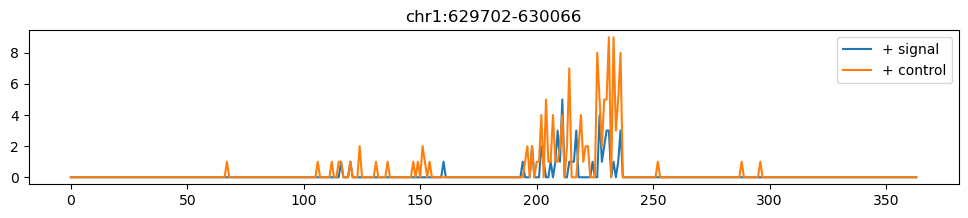

In [14]:
# Plot signal and control
seq_num = 0
ser = pos_sdata[["name", "chrom", "chromStart", "chromEnd"]].to_dataframe().loc[seq_num]
fig, ax = plt.subplots(figsize=(12,2))
plt.plot(pos_sdata["signal"][seq_num].values, label="+ signal")
plt.plot(pos_sdata["control"][seq_num].values, label="+ control")
plt.title(ser["chrom"] + ":" + ser["chromStart"].astype(str) + "-" + ser["chromEnd"].astype(str))
plt.legend()

# Negative strand

In [15]:
neg_peaks = os.path.join(data_dir, "peaks.crosslink.neg.bed")
neg_bw = [os.path.join(data_dir, "signal.neg.bw"), os.path.join(data_dir,"control.neg.bw")]
neg_names = ['signal', 'control']
neg_out = os.path.join(out_dir, "neg.zarr")

In [22]:
neg_sdata = sd.from_region_files(
    sd.GenomeFASTA(
        'seq',
        fasta,
        batch_size=2048,
        n_threads=4,
    ),
    sd.BigWig(
        'cov',
        neg_bw,
        neg_names,
        batch_size=2048,
        n_jobs=4,
        threads_per_job=2,
    ),
    path=neg_out,
    fixed_length=300,
    bed=neg_peaks,
    overwrite=True,
    max_jitter=32
)
neg_sdata.load()

100%|██████████| 221062/221062 [00:16<00:00, 13330.22it/s]


<xarray.Dataset>
Dimensions:     (_sequence: 221062, cov_sample: 2, _length: 364)
Coordinates:
  * cov_sample  (cov_sample) object 'signal' 'control'
Dimensions without coordinates: _sequence, _length
Data variables:
    chrom       (_sequence) object 'chr1' 'chr1' 'chr1' ... 'chrM' 'chrM' 'chrM'
    chromEnd    (_sequence) int64 730131 730156 736770 ... 14654 14679 16162
    chromStart  (_sequence) int64 729767 729792 736406 ... 14290 14315 15798
    cov         (_sequence, cov_sample, _length) uint16 0 0 0 0 0 ... 1 1 2 6 0
    name        (_sequence) object 'ENSG00000228327.4' ... 'ENSG00000210196.2'
    score       (_sequence) float64 2.0 2.0 2.0 2.0 2.0 ... 3.0 3.0 3.0 3.0 3.0
    seq         (_sequence, _length) |S1 b'C' b'A' b'C' b'T' ... b'T' b'G' b'T'
    strand      (_sequence) object '-' '-' '-' '-' '-' ... '-' '-' '-' '-' '-'
    thickEnd    (_sequence) int64 0 0 0 0 0 0 0 0 0 0 0 ... 0 0 0 0 0 0 0 0 0 0
    thickStart  (_sequence) int64 8 8 8 12 9 20 11 8 ... 91 67 73 74 66 97 413
Attributes:
    length_dim:    _length
    max_jitter:    32
    sequence_dim:  _sequence

In [23]:
# Split cov and control
neg_sdata['signal'] = (
    neg_sdata.cov.sel(cov_sample=['signal'])
    .drop_vars("cov_sample").squeeze()
)
neg_sdata['control'] = (
    neg_sdata.cov.sel(cov_sample=['control'])
    .drop_vars("cov_sample").squeeze()
)
# Get rid of aggregated cov
neg_sdata = neg_sdata.drop_vars("cov")
neg_sdata = neg_sdata.drop_vars("cov_sample")

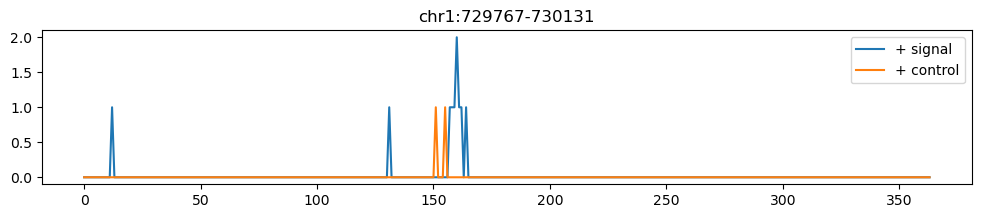

In [24]:
# Plot signal and control
seq_num = 0
ser = neg_sdata[["name", "chrom", "chromStart", "chromEnd"]].to_dataframe().loc[seq_num]
fig, ax = plt.subplots(figsize=(12,2))
plt.plot(neg_sdata["signal"][seq_num].values, label="+ signal")
plt.plot(neg_sdata["control"][seq_num].values, label="+ control")
plt.title(ser["chrom"] + ":" + ser["chromStart"].astype(str) + "-" + ser["chromEnd"].astype(str))
plt.legend()

# Full SeqData

In [25]:
# Concatenate them
sdata = xr.concat([pos_sdata, neg_sdata], dim="_sequence")

In [26]:
# Define training and validation chromosomes
training_chroms = ['chr{}'.format(i) for i in [3, 4, 5, 6, 7, 10, 11, 12, 13, 14, 17, 18, 19, 20, 21, 22]]
valid_chroms = ["chr1", "chr8", "chr15"]
test_chroms = ["chr2", "chr9", "chr16"]
len(training_chroms), len(valid_chroms), len(test_chroms)

(16, 3, 3)

In [27]:
# Keep only autosomes
sdata = sdata.sel(_sequence=((sdata["chrom"].isin(training_chroms + valid_chroms + test_chroms))))
sdata["chrom"].to_series().value_counts()

chr2     55124
chr1     33641
chr6     33385
chr3     26496
chr17    25967
chr12    22553
chr7     21363
chr16    21107
chr11    19442
chr20    19375
chr5     18608
chr14    17243
chr10    16806
chr9     15724
chr4     15718
chr8     13696
chr15    11285
chr19    10888
chr13    10492
chr22     6346
chr18     6094
chr21     4663
Name: chrom, dtype: int64

In [32]:
# Save full SeqData
sd.to_zarr(sdata, os.path.join(out_dir, 'both.zarr'), mode='w')

/cellar/users/aklie/opt/miniconda3/envs/ml4gland/lib/python3.9/site-packages/xarray/conventions.py:112: SerializationWarning: variable None has data in the form of a dask array with dtype=object, which means it is being loaded into memory to determine a data type that can be safely stored on disk. To avoid this, coerce this variable to a fixed-size dtype with astype() before saving it.
  warnings.warn(


In [33]:
# Create split columns
pp.train_test_chrom_split(sdata, test_chroms=["chr1", "chr8", "chr15"], train_var="train_test")
pp.train_test_chrom_split(sdata, test_chroms=["chr2", "chr9", "chr16"], train_var="train_val")

In [34]:
# Split SeqDatas
train_sdata = sdata.sel(_sequence=(sdata["train_val"] & sdata["train_test"]))
valid_sdata = sdata.sel(_sequence=~sdata["train_val"])
test_sdata = sdata.sel(_sequence=~sdata["train_test"])

In [35]:
# Check how many of each
train_sdata.dims["_sequence"], valid_sdata.dims["_sequence"], test_sdata.dims["_sequence"]

(275439, 91955, 58622)

In [36]:
# Save them
sd.to_zarr(train_sdata, os.path.join(out_dir, 'train.zarr'), mode='w')
sd.to_zarr(valid_sdata, os.path.join(out_dir, 'valid.zarr'), mode='w')
sd.to_zarr(test_sdata, os.path.join(out_dir, 'test.zarr'), mode='w')

/cellar/users/aklie/opt/miniconda3/envs/ml4gland/lib/python3.9/site-packages/xarray/conventions.py:112: SerializationWarning: variable None has data in the form of a dask array with dtype=object, which means it is being loaded into memory to determine a data type that can be safely stored on disk. To avoid this, coerce this variable to a fixed-size dtype with astype() before saving it.
  warnings.warn(
/cellar/users/aklie/opt/miniconda3/envs/ml4gland/lib/python3.9/site-packages/xarray/conventions.py:112: SerializationWarning: variable None has data in the form of a dask array with dtype=object, which means it is being loaded into memory to determine a data type that can be safely stored on disk. To avoid this, coerce this variable to a fixed-size dtype with astype() before saving it.
  warnings.warn(
/cellar/users/aklie/opt/miniconda3/envs/ml4gland/lib/python3.9/site-packages/xarray/conventions.py:112: SerializationWarning: variable None has data in the form of a dask array with dtype=

# DONE!

----